In [3]:
import pandas as pd
import numpy as np
import os
import json
import glob
import matplotlib as plt
import spacy
from yellowbrick.text import TSNEVisualizer

# Download data from Kaggle and load

In [5]:
root = 'C:/Users/brian/Documents/GitHub/COVID19_RESEARCH'
meta_path = os.path.join(root, 'metadata.csv')

meta_df = pd.read_csv(meta_path)
meta_df.head()


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


# Clean the data for processing

In [6]:
meta_df.shape

(52398, 18)

In [8]:
meta_df = meta_df[['cord_uid', 'title', 'abstract', 'publish_time', 'authors']]
meta_df.isnull().sum()

cord_uid           0
title            158
abstract        9230
publish_time       8
authors         2279
dtype: int64

In [9]:
meta_df = meta_df.dropna(subset=['title', 'abstract'])
meta_df.shape

(43019, 5)

In [11]:
check_duplicates = ['cord_uid','title', 'abstract', 'authors']

for head in check_duplicates:
    meta_df = meta_df.drop(meta_df[meta_df[f'{head}'].duplicated()].index)

#Check duplicates are empty
[(meta_df[meta_df[f'{head}'].duplicated()]) for head in check_duplicates]


[Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors]
 Index: []]

In [12]:
meta_df.shape

(41125, 5)

In [13]:
text = meta_df
text[:10]

,cord_uid,title,abstract,publish_time,authors
0,xqhn0vbp,Airborne rhinovirus detection and effect of ul...,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn..."
1,gi6uaa83,Discovering human history from stomach bacteria,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R"
2,le0ogx1s,A new recruit for the army of the men of death,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A"
3,fy4w7xz8,Association of HLA class I with severe acute r...,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean..."
4,0qaoam29,A double epidemic model for the SARS propagation,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine"
5,qj4dh6rg,Cloaked similarity between HIV-1 and SARS-CoV ...,BACKGROUND: Severe acute respiratory syndrome ...,2003-09-21,"Kliger, Yossef; Levanon, Erez Y"
6,1wswi7us,Relationship of SARS-CoV to other pathogenic R...,BACKGROUND: The exact origin of the cause of t...,2003-09-20,"Yap, Yee Leng; Zhang, Xue Wu; Danchin, Antoine"
7,yy96yeu9,Viral Discovery and Sequence Recovery Using DN...,Because of the constant threat posed by emergi...,2003-11-17,"Wang, David; Urisman, Anatoly; Liu, Yu-Tsueng;..."
8,5o38ihe0,"A model of tripeptidyl-peptidase I (CLN2), a u...","BACKGROUND: Tripeptidyl-peptidase I, also know...",2003-11-11,"Wlodawer, Alexander; Durell, Stewart R; Li, Mi..."
9,1ul8owic,Air pollution and case fatality of SARS in the...,BACKGROUND: Severe acute respiratory syndrome ...,2003-11-20,"Cui, Yan; Zhang, Zuo-Feng; Froines, John; Zhao..."


# Lemmatizatin/Stop word Reduction

In [14]:
nlp = spacy.load('en_core_web_lg', disable=['tagger','parser','ner'])

In [15]:
def tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or len(word)==1)]

# TF_IDF Vectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
vec = TfidfVectorizer(tokenizer = tokenizer, max_df=0.90, min_df=2)

In [18]:
tfidf = vec.fit_transform(text['abstract'])

In [73]:
tfidf

<41125x46020 sparse matrix of type '<class 'numpy.float64'>'
	with 3241706 stored elements in Compressed Sparse Row format>

# Latent Dirichlet Allocation

In [50]:
from sklearn.decomposition import LatentDirichletAllocation

In [21]:
lda = LatentDirichletAllocation(n_components=60,random_state=42)

In [22]:
lda.fit(tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=60, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [23]:
for index,topic in enumerate(lda.components_[:10]):
    print(f'Top 10 words for topic #{index} are:')
    print([vec.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n\n')

Top 10 words for topic #0 are:
['antibody', 'viral', 'antiviral', 'infection', 'drug', 'cov', 'sars', 'human', 'virus', 'vaccine']



Top 10 words for topic #1 are:
['wm', 'pvm', 'bn', 'cd3', 'nef', 'autoreactive', 'sirt1', 'vpu', 'foal', 'lamb']



Top 10 words for topic #2 are:
['isolate', 'sequence', 'response', 'ibv', 'bat', 'infection', 'strain', 'mouse', 'cell', 'virus']



Top 10 words for topic #3 are:
['toxoplasma', 'trypanosoma', 'sinensis', 'basolateral', 'vimentin', 'isgylation', 'cruzi', 'gondii', 't.', 'nec']



Top 10 words for topic #4 are:
['clostridium', 'ipc', 'c.', 'hais', 'viroporin', 'saa', 'marine', 'difficile', 'hbov1', 'ferret']



Top 10 words for topic #5 are:
['care', 'research', 'pandemic', 'risk', 'global', 'outbreak', 'infectious', 'public', 'disease', 'health']



Top 10 words for topic #6 are:
['dfa', 'amantadine', 'calve', 'poct', 'cryptosporidiosis', 'c.', 'rvp', 'oocyst', 'parvum', 'cryptosporidium']



Top 10 words for topic #7 are:
['frc', 'icwm', 

In [74]:
text['topic'] = lda.transform(tfidf).argmax(axis=1)


In [77]:

def paper_by_topic(topic):
    print("---------There are " + str(len(text[text['topic'] == topic])) + " Articles in this topic cluster.---------")
    return text[text['topic'] == topic]['title']

for i in text['topic'].unique():
    paper_by_topic(i)

---------There are 2472 Articles in this topic cluster.---------
---------There are 6001 Articles in this topic cluster.---------
---------There are 5832 Articles in this topic cluster.---------
---------There are 5417 Articles in this topic cluster.---------
---------There are 2300 Articles in this topic cluster.---------
---------There are 11601 Articles in this topic cluster.---------
---------There are 2296 Articles in this topic cluster.---------
---------There are 2730 Articles in this topic cluster.---------
---------There are 1038 Articles in this topic cluster.---------
---------There are 624 Articles in this topic cluster.---------
---------There are 4 Articles in this topic cluster.---------
---------There are 16 Articles in this topic cluster.---------
---------There are 21 Articles in this topic cluster.---------
---------There are 81 Articles in this topic cluster.---------
---------There are 3 Articles in this topic cluster.---------
---------There are 15 Articles in thi

In [78]:
count_by_topic = text['topic'].value_counts()


Text(0, 0.5, 'Papers (Qty)')

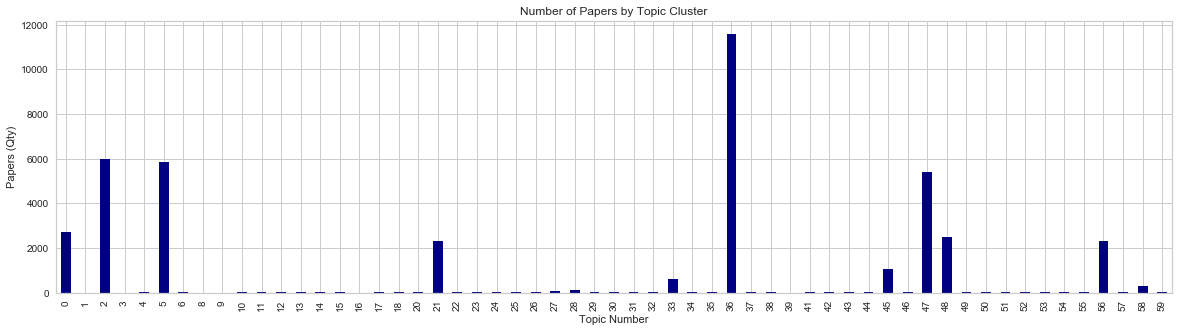

In [79]:
topic_chart = count_by_topic.sort_index().plot(kind = 'bar', title = 'Number of Papers by Topic Cluster', colormap='jet', figsize =(20,5))
topic_chart.set_xlabel("Topic Number")
topic_chart.set_ylabel("Papers (Qty)")

# K-means Clustering

In [27]:
from sklearn.cluster import KMeans

In [ ]:
#kmeans = KMeans(n_clusters=60).fit(tfidf)

In [ ]:
#kmeans

# Visualizations

In [80]:
tsne = TSNEVisualizer()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

TSNEVisualizer(alpha=0.7,
        ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001F44A821748>,
        classes=None, colormap=None, colors=None, decompose=None,
        decompose_by=None, labels=None, random_state=None)

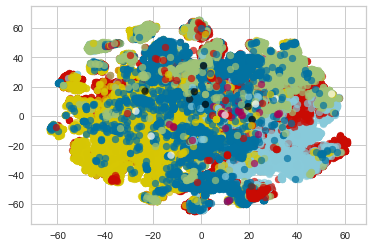

In [81]:
tsne.fit(tfidf, text['topic'])

In [82]:
tsne.poof()